In [1]:
## Import packages and functions needed to plot and access the NOMAD Data

!pip install plotly ipywidgets>=7.6
import plotly.io as pio
pio.renderers.default='iframe'

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from api_calls_get_data import get_specific_data_of_sample, get_entryid, get_quantity_over_jv



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\hr0264\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
## Define Batch and Sample IDs for Evaluation 

sample_ids = [f"KIT_DaBa_20231103_CE_3_{j}" for j in range(5)]\
            +[f"KIT_DaBa_20231004_GQ160_0_{j}" for j in range(6)]
            
samples_of_batch = [(sample_id, get_entryid(sample_id)) for sample_id in sample_ids]


In [3]:
samples_of_batch

[('KIT_DaBa_20231103_CE_3_0', 'w-JbQ5Dyloq-oQUPD2sViiD8GXuS'),
 ('KIT_DaBa_20231103_CE_3_1', 'hgW-BUbtrKF4qd7rsNf2Nv6txKTU'),
 ('KIT_DaBa_20231103_CE_3_2', 'giiM5Fp_b4rP9OZsO2cvJheSZMh6'),
 ('KIT_DaBa_20231103_CE_3_3', '1gEnl4Y_AZoJbZgPxBYLQN1fo7LN'),
 ('KIT_DaBa_20231103_CE_3_4', 'yJW--nQeDQyMuX2abH2_EdgHBxPj'),
 ('KIT_DaBa_20231004_GQ160_0_0', 'nzq8sG8mPN3Wjvw3X8rhYtoIhEFW'),
 ('KIT_DaBa_20231004_GQ160_0_1', '8hxD3zr-J9T0DhbPe10SbpB1rEBt'),
 ('KIT_DaBa_20231004_GQ160_0_2', '2t0BhSpJ15bKdYxqTJZNkghj1Hqc'),
 ('KIT_DaBa_20231004_GQ160_0_3', '6EiaZFAc2HZV4GmB_PG_zP9WJfVd'),
 ('KIT_DaBa_20231004_GQ160_0_4', 'zbuaR9vG7jL5y4gzc-5Qj31SWzCt'),
 ('KIT_DaBa_20231004_GQ160_0_5', 'zUJrv_Ndr-Ej5yVdrwKhbjoaxOEw')]

In [4]:
## Import Data from NOMAD as dataframe
## Modify quantities to the values you have changed and the key to the process you have used taht includes the variation 

quantities=["name"]

jv_quantities=["efficiency",\
               "fill_factor",\
               "open_circuit_voltage",\
               "short_circuit_current_density"]

key = ["peroTF_CR_SpinBox_SpinCoating"]

df = get_quantity_over_jv(samples_of_batch, key, quantities, jv_quantities)

In [5]:
## Extract Info from ID

df['last_digit'] = df['sample_id'].str.extract('(\d)$').astype(int)[0]
df['category'] = df['sample_id'].str.split('_').str[4]
df['batch_name'] = df['sample_id'].str.split('_').str[3]
df['batch_date'] = df['sample_id'].str.split('_').str[2]

In [6]:
df

,sample_id,name,efficiency,fill_factor,open_circuit_voltage,short_circuit_current_density,last_digit,category,batch_name,batch_date
entry_id,,,,,,,,,,
w-JbQ5Dyloq-oQUPD2sViiD8GXuS,KIT_DaBa_20231103_CE_3_0,"Spin Pero Robot*,22.10.2023 08:00",19.42412,0.793481,1.122948,21.79943,0,3,CE,20231103
w-JbQ5Dyloq-oQUPD2sViiD8GXuS,KIT_DaBa_20231103_CE_3_0,"Spin Pero Robot*,22.10.2023 08:00",18.92981,0.781338,1.114904,21.73050,0,3,CE,20231103
w-JbQ5Dyloq-oQUPD2sViiD8GXuS,KIT_DaBa_20231103_CE_3_0,"Spin Pero Robot*,22.10.2023 08:00",18.89517,0.795978,1.119659,21.20137,0,3,CE,20231103
w-JbQ5Dyloq-oQUPD2sViiD8GXuS,KIT_DaBa_20231103_CE_3_0,"Spin Pero Robot*,22.10.2023 08:00",18.47483,0.786814,1.111393,21.12715,0,3,CE,20231103
w-JbQ5Dyloq-oQUPD2sViiD8GXuS,KIT_DaBa_20231103_CE_3_0,"Spin Pero Robot*,22.10.2023 08:00",19.14128,0.792507,1.121721,21.53194,0,3,CE,20231103
...,...,...,...,...,...,...,...,...,...,...
zUJrv_Ndr-Ej5yVdrwKhbjoaxOEw,KIT_DaBa_20231004_GQ160_0_5,"Spin Pero 160,12",15.86642,0.746808,0.995040,21.35155,5,0,GQ160,20231004
zUJrv_Ndr-Ej5yVdrwKhbjoaxOEw,KIT_DaBa_20231004_GQ160_0_5,"Spin Pero 160,12",17.27949,0.785697,1.032025,21.31011,5,0,GQ160,20231004
zUJrv_Ndr-Ej5yVdrwKhbjoaxOEw,KIT_DaBa_20231004_GQ160_0_5,"Spin Pero 160,12",16.84903,0.778068,1.016633,21.30067,5,0,GQ160,20231004


In [7]:
#name_mapping = {
#    'Spin Pero WBG 150': 'WBG',
#    'Spin Pero Robot*,22.10.2023 08:00': 'Robot Ref',
#    'Spin Pero  160,12': 'Gas Quenched'
#}

# Replace the names in the 'Category' column
#df['name'] = df['name'].replace(name_mapping)

In [8]:
## Data cleaning remove shunted or somehow damaged devices using filters

df = df[df['fill_factor'] >= 0.5]
df = df[df['open_circuit_voltage'] >= 0.8]
df = df[df["fill_factor"] <= 1]

In [9]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Calculate std, median, maximum of different groups
result_df = pd.DataFrame(columns=['category',
                                  'standard_deviation',
                                  'median',
                                  'closest_median',
                                  'closest_median_id',
                                  'maximum_efficiency',
                                  'maximum_efficiency_id'])

for index, category in enumerate(sorted(df[quantities[0]].unique())):
    # Calculate standard deviation
    std_dev = df[df[quantities[0]] == category]['efficiency'].std()
    # Median and closest value to median
    med_eff = df[df[quantities[0]] == category]['efficiency'].median()
    closest_med_eff_value = sorted(df[df[quantities[0]] == category]['efficiency'],
                                   key=lambda x: abs(x - med_eff - 0.000000001))[:1]
    med_id = df[df['efficiency'] == closest_med_eff_value[0]]['sample_id'].values[0]
    # Maximum efficiency value
    max_eff = df[df[quantities[0]] == category]['efficiency'].max()
    max_id = df[df['efficiency'] == max_eff]['sample_id'].values[0]

    # Create a temporary DataFrame with the current results
    temp_df = pd.DataFrame({
        'category': [category],
        'standard_deviation': [std_dev],
        'median': [med_eff],
        'closest_median': [closest_med_eff_value[0]],
        'closest_median_id': [med_id],
        'maximum_efficiency': [max_eff],
        'maximum_efficiency_id': [max_id]
    })

    # Concatenate the temporary DataFrame with the result DataFrame
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Perform ANOVA test
f_statistic, p_value = f_oneway(*[group['efficiency'] for name, group in df.groupby(quantities[0])])

if p_value < 0.05:
    # Perform Tukey HSD test
    tukey_results = pairwise_tukeyhsd(df['efficiency'], df[quantities[0]], alpha=0.05)
    print(tukey_results)
else:
    print("No significant differences between group means.")

std_median = round(np.std(result_df['median']), 2)
std_total = round(df['efficiency'].std(), 2)

C:\Users\hr0264\AppData\Local\Temp\ipykernel_22928\1159486860.py:37: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1      group2  meandiff p-adj lower  upper  reject
----------------------------------------------------------
Gas Quenched Robot Ref   2.6204   0.0 1.8827 3.3582   True
----------------------------------------------------------


In [10]:
result_df

,category,standard_deviation,median,closest_median,closest_median_id,maximum_efficiency,maximum_efficiency_id
0,Gas Quenched,2.121965,16.36212,16.37144,KIT_DaBa_20231004_GQ160_0_5,18.53779,KIT_DaBa_20231004_GQ160_0_0
1,Robot Ref,0.908683,18.45712,18.47483,KIT_DaBa_20231103_CE_3_0,19.59856,KIT_DaBa_20231103_CE_3_2


In [11]:
def plot_JV_curves(result_df, curve_type):
    fig, ax = plt.subplots()
    
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(result_df)))
    
    # Set the color cycle for the axes
    ax.set_prop_cycle(color=colors)
    
    for index, row in result_df.iterrows():
        jv_data = get_specific_data_of_sample(row[f'{curve_type}_id'], "JVmeasurement")
        for cell in jv_data:
            for i in range(2):
                if cell["jv_curve"][i]["efficiency"] == row[f'{curve_type}'] and \
                   (curve_type == 'maximum_efficiency' or curve_type == 'closest_median'):
                        ax.plot(cell["jv_curve"][i]["voltage"], \
                                 cell["jv_curve"][i]["current_density"], \
                                 label=f"{row['category']}")
                        print(cell["name"])
                        break

    # Plot settings
    ax.legend()
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-5, 25)
    ax.set_title(f'{curve_type.capitalize()} JV Curves', fontsize=16)
    ax.set_xlabel('Voltage (V)', fontsize=12)
    ax.set_ylabel('Short Circuit Current (mA/cm²)', fontsize=12)

    # Axis ticks and borders
    ax.tick_params(axis='both', which='both', direction='in', width=2, bottom=1, top=1, left=1, right=1)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Zero lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    #fig.savefig(f"{curve_type}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig


KIT_DaBa_20231004_GQ160_0_5 px3
KIT_DaBa_20231103_CE_3_0 px1


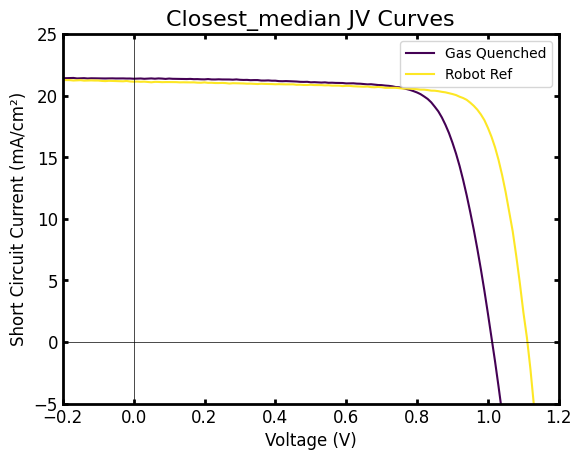

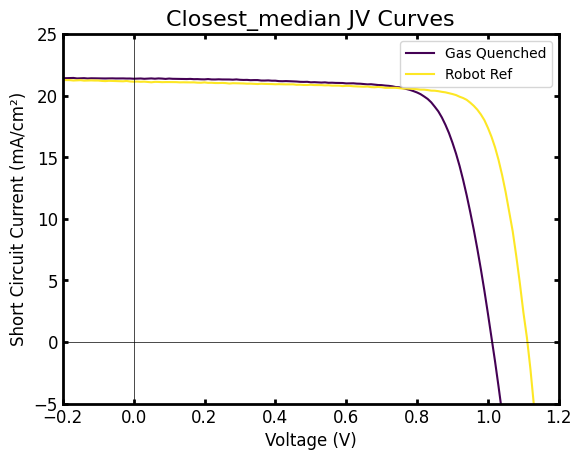

In [12]:
plot_JV_curves(result_df, 'closest_median')

KIT_DaBa_20231004_GQ160_0_0 px3
KIT_DaBa_20231103_CE_3_2 px4


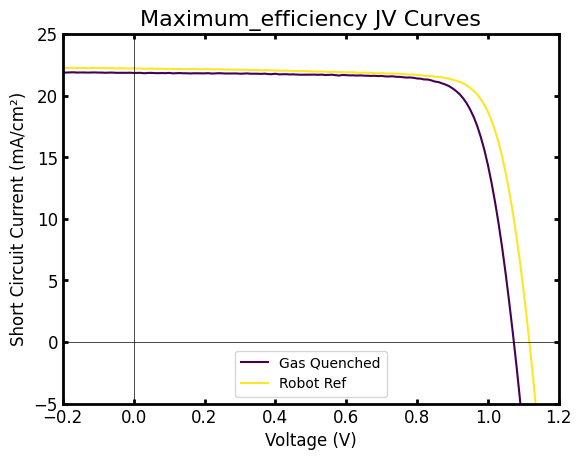

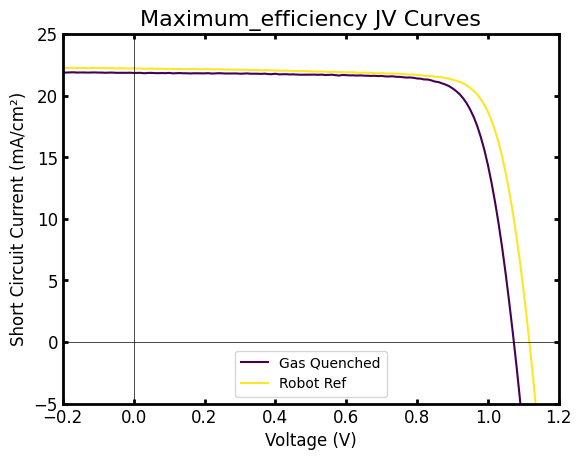

In [13]:
plot_JV_curves(result_df, 'maximum_efficiency')

In [14]:
def plot_box_and_scatter(df, quantities, jv_quantity):
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(df[quantities[0]].unique())))
    
    # Define Y-Axis Labels
    quantity_labels = {
        'open_circuit_voltage': 'Open Circuit Voltage (V)',
        'fill_factor': 'Fill Factor (%)',
        'efficiency': 'Efficiency (%)',
        'short_circuit_current_density': 'Short Circuit Current Density (mA/cm²)'
    }

    fig, ax = plt.subplots(figsize=(10, 5))

    positions = [i + 1 for i in range(len(df[quantities[0]].unique()))]  # Define positions for each group

    # Draw the box plot without fliers and with colors
    boxprops = dict(facecolor='white', color='black')
    medianprops = dict(color='red')
    for i, (group, color) in enumerate(zip(df[quantities[0]].unique(), colors)):
        group_data = df[df[quantities[0]] == group][jv_quantity]
        box = ax.boxplot(group_data, positions=[positions[i]], showmeans=False, showfliers=False, widths=0.5, patch_artist=True,
                          boxprops=dict(facecolor=color, color='black'),
                          medianprops=medianprops)

    # Overlay the scatter plot with black points
    for i, group in enumerate(df[quantities[0]].unique()):
        group_data = df[df[quantities[0]] == group]
        # Add jitter to x positions
        jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(group_data))
        ax.scatter(jittered_x, group_data[jv_quantity], color='black', alpha=1, zorder=3)

    # Axis label and Ticks
    ax.set_ylabel(f"{quantity_labels[jv_quantity]}", size=16)
    ax.set_xticks(positions)
    ax.set_xticklabels(df[quantities[0]].unique(), size=14)
    ax.set_yticks(ax.get_yticks())
    ax.tick_params(axis='both', labelsize=14)

    # Border line and Ticks Formatting
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='both', right=True, top=True, direction='in', width=2, colors='black', length=5)

    # Transparent Background
    fig.patch.set_facecolor('none')
    ax.patch.set_facecolor('none')

    # Save the figure
    #fig.savefig(f"{jv_quantity}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig


In [102]:
[quantities[0]]

['name']

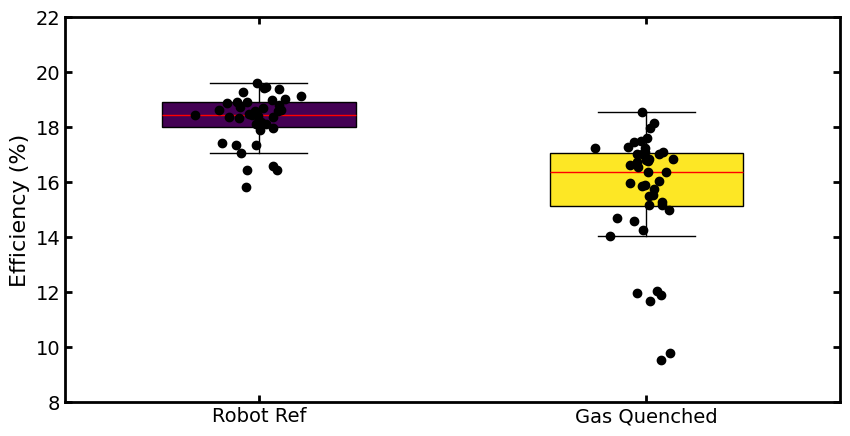

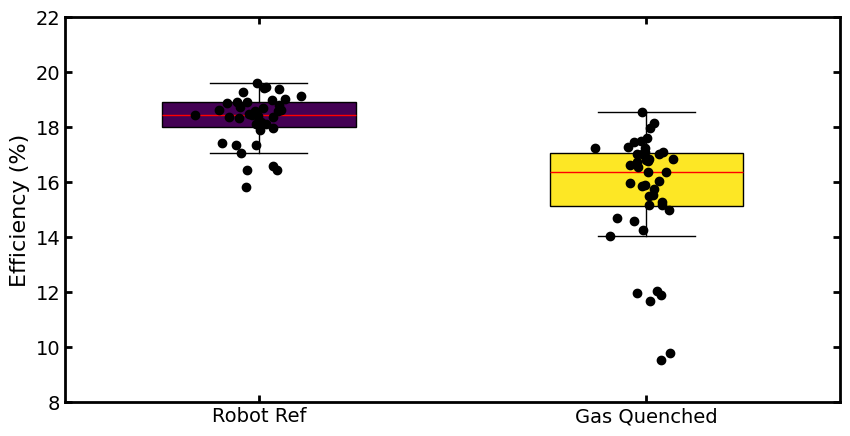

In [15]:
plot_box_and_scatter(df, [quantities[0]], 'efficiency')

In [164]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pandas as pd

def generate_pdf_report(result_df):
    with PdfPages('report.pdf') as pdf:
        # Plot the maximum JV curves
        fig_max = plot_JV_curves(result_df, 'maximum_efficiency')
        pdf.savefig(fig_max, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_max)

        # Plot the median JV curves
        fig_med = plot_JV_curves(result_df, 'closest_median')
        pdf.savefig(fig_med, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_med)

        # Add any other plots or content to the PDF here
        fig_eff = plot_box_and_scatter(df, [quantities[0]], 'efficiency')
        pdf.savefig(fig_eff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_eff)
        
        fig_ff = plot_box_and_scatter(df, [quantities[0]], 'fill_factor')
        pdf.savefig(fig_ff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_ff)
        
        fig_voc = plot_box_and_scatter(df, [quantities[0]], 'open_circuit_voltage')
        pdf.savefig(fig_voc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_voc)
        
        fig_jsc = plot_box_and_scatter(df, [quantities[0]], 'short_circuit_current_density')
        pdf.savefig(fig_jsc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_jsc)
        
        # Add result_df as a table to the PDF
        fig_table, ax_table = plt.subplots(figsize=(10, 5))
        ax_table.axis('off')  # Hide axis
        table = ax_table.table(cellText=result_df.values, colLabels=result_df.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        pdf.savefig(fig_table, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_table)

    print("PDF report generated successfully.")

# Call the function with your result_df DataFrame
generate_pdf_report(result_df)


KIT_DaBa_20240522_WBGTest_0_1 px3
KIT_DaBa_20240522_WBGTest_1_1 px1
KIT_DaBa_20240522_WBGTest_2_0 px2
KIT_DaBa_20240522_WBGTest_0_3 px3
KIT_DaBa_20240522_WBGTest_1_2 px1
KIT_DaBa_20240522_WBGTest_2_1 px3
PDF report generated successfully.


In [86]:
fig = go.Figure()

group_colors = {
    'WBG': 'blue',
    'Robot Ref': 'purple',
    'Gas Quenched': 'yellow',
}


for batch in df['name'].unique():
    #print(group_colors[group])
    group_data = df[df['name'] == batch]
    fig.add_trace(go.Box(
                y = group_data['efficiency'],
                x = group_data['batch_date'],
                name=batch,
                boxpoints='all',
                marker=dict(color=group_colors[batch])
                        )
                 )
    
    
fig.update_layout(
    #boxmode='group',  # Group the boxes
    #xaxis=dict(title='Batch Number'),  # X-axis label
    yaxis=dict(range=[10, 20]),  # Y-axis label
    #title=f'Grouped Box Plots with Group Names'
    height=600,  # Set the height of the plot
    width=1200    # Set the width of the plot
)
#layout.yaxis.title.font
fig.update_layout(showlegend=False, paper_bgcolor='rgba(0,0,0,0)',  plot_bgcolor='rgba(0,0,0,0)')
fig.update_xaxes(ticks="inside", tickwidth=3, tickcolor='black', ticklen=5,\
                 showline=True, linewidth=4, linecolor='black', showgrid=False,\
                 mirror=True, showticklabels=False)
fig.update_yaxes(ticks="inside", tickwidth=3, tickcolor='black', ticklen=5,\
                 showline=True, linewidth=4, linecolor='black', showgrid=True,\
                 mirror=True, rangemode='nonnegative', title="PCE(%)", title_font=dict(size=20),\
                 tickfont=dict(size=16))

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed